In [4]:
import pystan as stan
from scipy.special import logit, expit
from numpy.random import normal, choice, binomial, uniform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
#ckmr_model = stan.CmdStanModel(stan_file='~/src/ckmr/src/sib.stan')
ckmr_model_full = stan.StanModel(file='/home/alex/src/ckmr/src/sib_full.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8d934be5c269905fda08f39698ecc82d NOW.


In [3]:
df = pd.read_excel('PIRU_mykiss_parentage.xlsx')
df = df[df['Count'] > 0]
df = df[['Count']]

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [44]:
def preprocess_data(df):
    df = df[['OffspringID', 'MotherID', 'FatherID']]
    df = df.groupby(['MotherID', 'FatherID'], as_index=False).count()
    df = df.rename(columns={'OffspringID': 'Count'})
    df = df[df['Count'] > 0]
    return df
    
def sub_sample(df, p=0.1):
    tot = df['Count'].sum()
    new_count = binomial(df['Count'], p)
    df1 = df[set(df.columns).difference({'Count'})]
    df1['Count'] = new_count
    df1 = df1[df1['Count'] > 0]
    return df1
    

def make_stan_data(df, method='normal', osr=[0.0, 0.01], prom=[-2.5, 0.11]):
    if method == 'normal':
        method = 1
    elif method == 'beta':
        method = 2
    else:
        raise ValueError(f'Invalid method: {method}')
    data = {
        'method': method,
        'osr_mu': osr[0],
        'osr_sigma': osr[1],
        'G': len(df['Count']),
        'M': df['FatherID'].nunique(),
        'F': df['MotherID'].nunique(),
        'N': df['Count'].sum(),
        'grp_size': df['Count'].values
    }
    return data

def plot_results(dfs, field='F0', ci=0.99, title='', ax=None):
    dfs = summarize_samples(dfs, ci=ci, field=field)
    ns = [d[0] for d in dfs]
    summaries = [d[1] for d in dfs]
    if ax is None:
        _, ax = plt.subplots(figsize=(16, 9))
    y0 = [s[field].loc['mean'] for s in summaries]
    y1 = [s[field].iloc[4] for s in summaries]
    y2 = [s[field].iloc[6] for s in summaries]
    ax.plot(ns, y0, 'o-', label='mean')
    ax.fill_between(ns, y1, y2, alpha=0.5, label=f'{(100*ci):.1f}% CI')
    ax.set_xlabel('sample size')
    ax.set_ylabel(f'{field} estimate')
    ax.set_title(title)
    return ax
    
def sample_data(dfs, method='normal', **kwargs):
    fits = [(d['Count'].sum(), ckmr_model_full.sampling(data=make_stan_data(d, method=method), **kwargs)) for d in dfs]
    fits.sort(key=(lambda x: x[0]))
    return fits

def summarize_samples(fits, ci=0.99, field='F0'):
    lower = 0.5 * (1.0 - ci)
    upper = 1.0 - lower
    quants = (lower, upper)
    res = [(n, d.to_dataframe(pars=[field]).describe(percentiles=quants)) for (n, d) in fits]
    return res
    
def make_synth_data(M0, F0, G0, N):
    N0 = M0 + F0
    ms = choice(M0, size=G0, replace=True)
    fs = choice(F0, size=G0, replace=True)
    xs = choice(G0, size=N)
    df = pd.DataFrame(data={'OffspringID': np.arange(N), 'FatherID': ms[xs], 'MotherID': fs[xs]})
    return df

In [5]:
dfs = (sub_sample(df, p=p) for p in np.arange(0.05, 1.0, 0.05))
fits = sample_data(dfs, chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

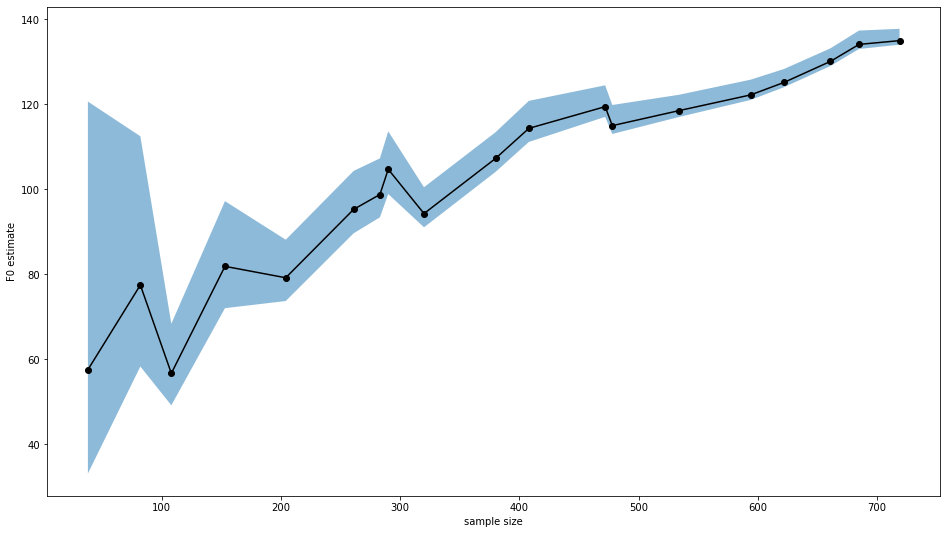

In [6]:
plot_results(fits, field='F0')

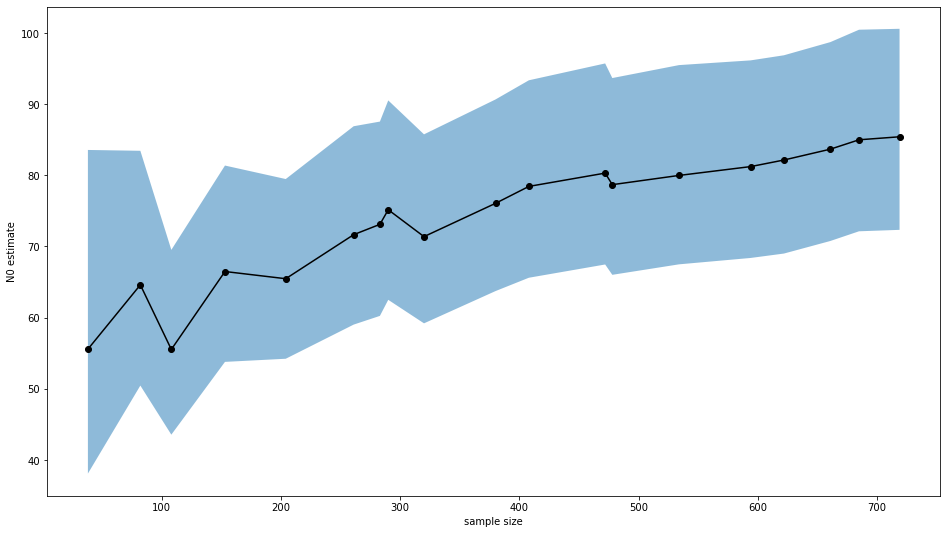

In [7]:
plot_results(fits, field='N0')

In [8]:
dfs1 = (make_synth_data(137, N) for N in range(100, 1000, 100))
fits1 = sample_data(dfs1, chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

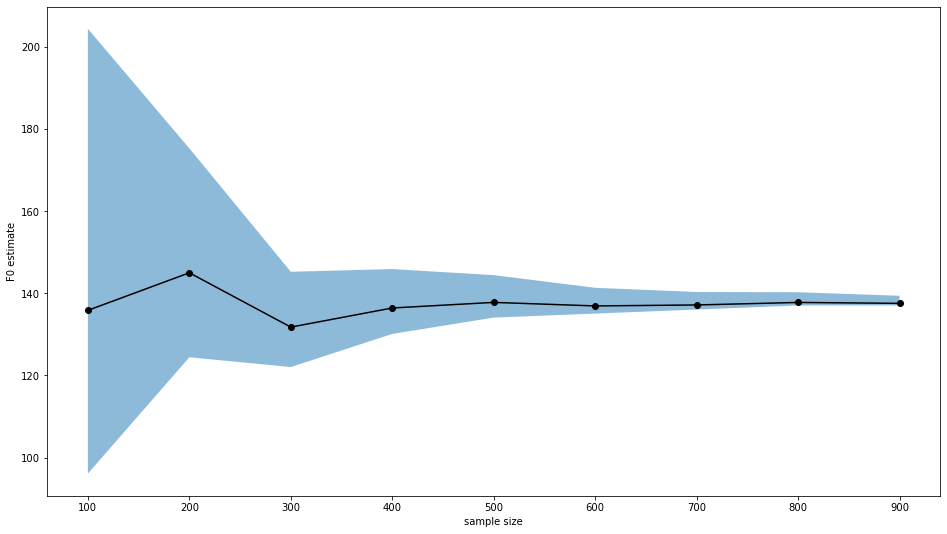

In [9]:
plot_results(fits1, field='F0')

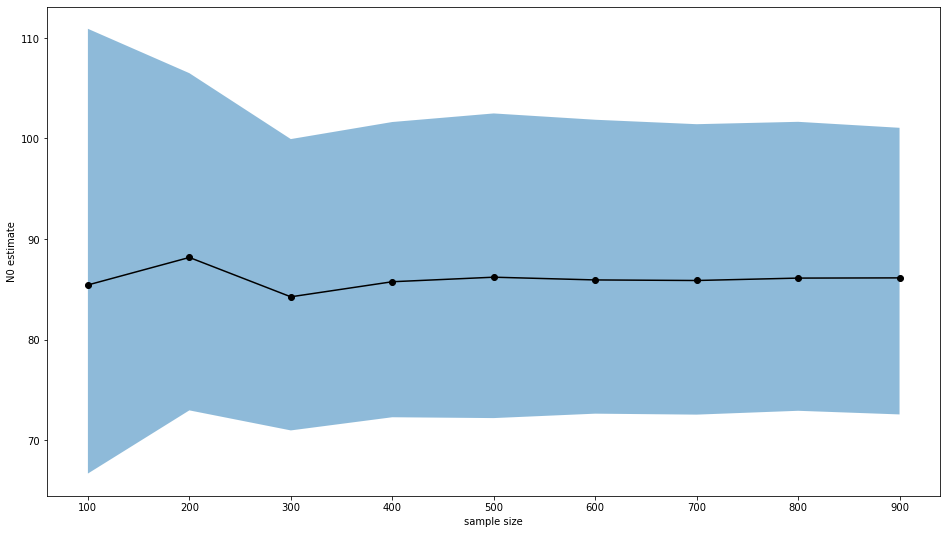

In [10]:
plot_results(fits1, field='N0')

In [4]:
dfs2 = (make_synth_data(1234, N) for N in range(200, 2200, 200))
fits2 = sample_data(dfs2, chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

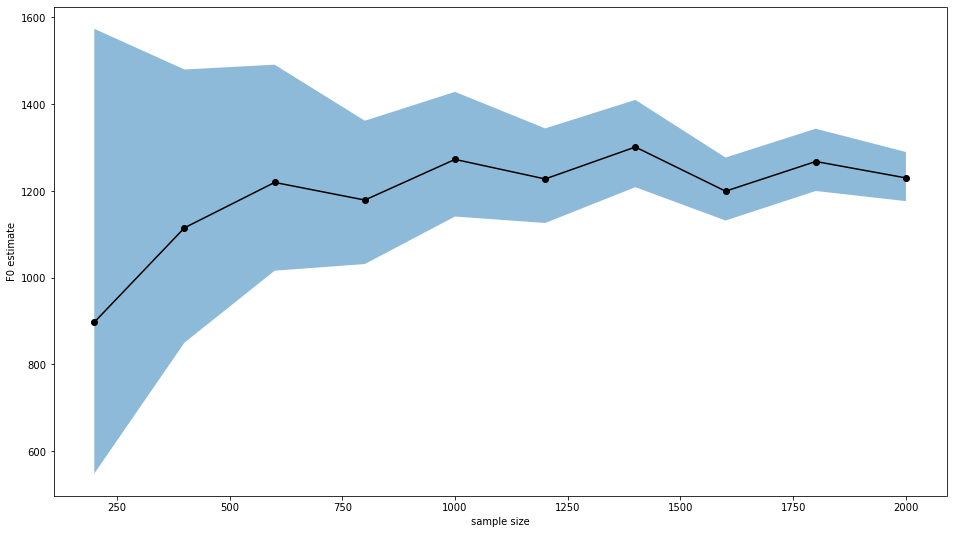

In [5]:
plot_results(fits2, field='F0')

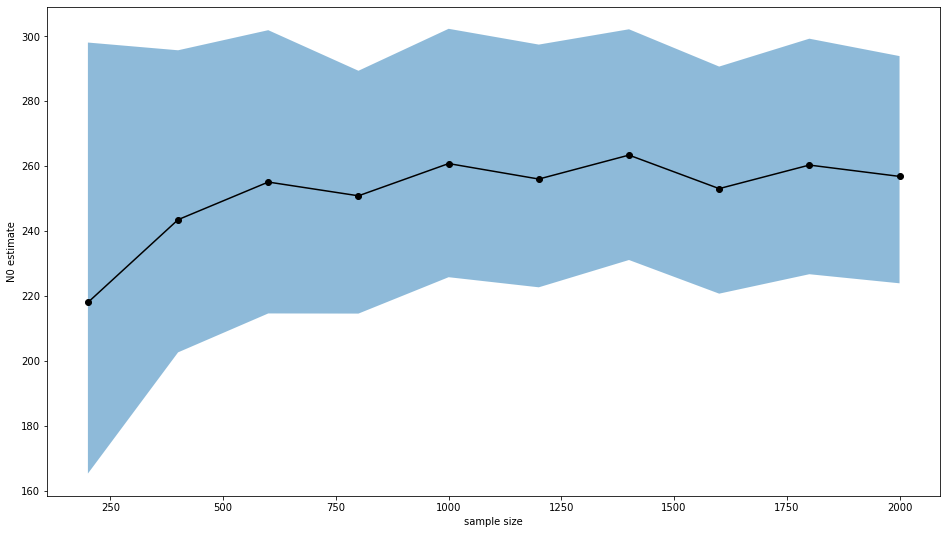

In [6]:
plot_results(fits2, field='N0')

In [26]:
df3 = preprocess_data(pd.read_csv('/home/alex/src/ckmr/Stan_mykiss_2021_Run1.BestConfig'))

In [27]:
df3

,MotherID,FatherID,Count
0,1,1,1
1,2,2,1
2,3,3,2
3,4,4,1
4,5,5,1
...,...,...,...
125,126,126,2
126,127,127,1
127,128,128,1
128,129,129,1


In [29]:
dfs3 = [sub_sample(df3, p=p) for p in np.linspace(0.2, 1.0, 18)]
norm3 = sample_data(dfs3, method='normal', chains=4, iter=2000)
beta3 = sample_data(dfs3, method='beta', chains=4, iter=2000)

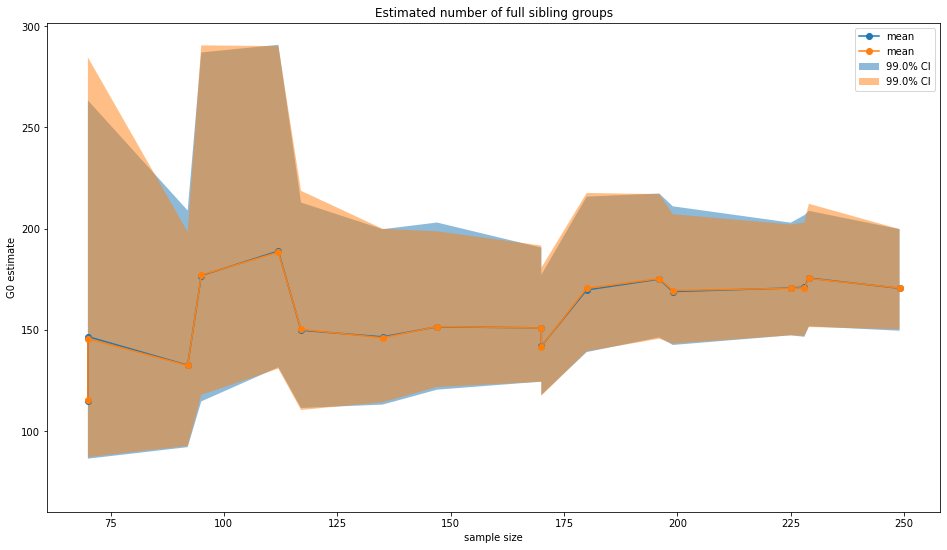

In [31]:
ax = plot_results(norm3[1:], field='G0', title='Estimated number of full sibling groups')
ax = plot_results(beta3[1:], field='G0', title='Estimated number of full sibling groups', ax=ax)
ax.legend()

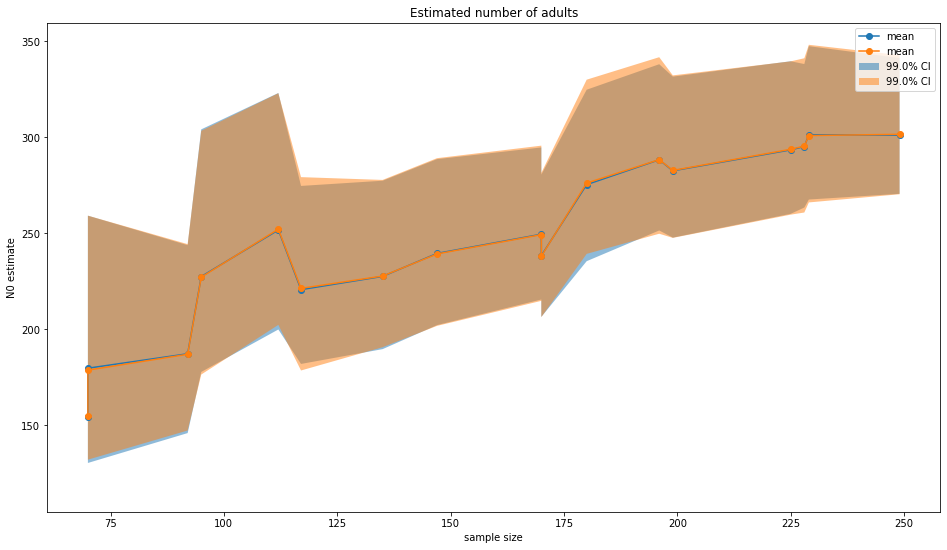

In [32]:
ax = plot_results(norm3[1:], field='N0', title='Estimated number of adults')
ax = plot_results(beta3[1:], field='N0', title='Estimated number of adults', ax=ax)
ax.legend()

In [33]:
norm3[-1][1].to_dataframe(pars=['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])

,chain,draw,warmup,F0,G0,M0,N0,osr,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
count,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000
mean,1.500000,499.500000,0.0,150.499379,170.519740,150.441335,300.940714,0.500009,0.890330,0.631324,2.550250,6.368500,0.0,681.661859
std,1.118174,288.711081,0.0,10.928620,9.575841,10.761380,14.455870,0.002453,0.149533,0.091362,0.577978,3.706702,0.0,2.159251
min,0.000000,0.000000,0.0,130.165833,142.582289,130.043883,261.874684,0.491952,0.009119,0.548741,1.000000,1.000000,0.0,677.655880
0.5%,0.000000,4.995000,0.0,130.639012,149.559339,130.825139,270.436917,0.493923,0.179023,0.548741,1.000000,1.000000,0.0,678.068774
50%,1.500000,499.500000,0.0,149.742407,169.815990,149.822891,300.283428,0.500003,0.947217,0.598421,3.000000,7.000000,0.0,681.295231
99.5%,3.000000,994.005000,0.0,181.776266,199.761694,179.724221,341.076734,0.506225,1.000000,0.779715,4.000000,31.000000,0.0,689.231303
max,3.000000,999.000000,0.0,192.163046,217.873121,191.398346,362.107517,0.507724,1.000000,0.779715,5.000000,55.000000,0.0,691.384751


In [34]:
beta3[-1][1].to_dataframe(pars=['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])

,chain,draw,warmup,F0,G0,M0,N0,osr,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
count,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000
mean,1.500000,499.500000,0.0,150.720637,170.647152,150.674531,301.395168,0.499988,0.919678,0.554711,2.628750,6.231000,0.0,683.384300
std,1.118174,288.711081,0.0,10.392515,9.528932,10.578725,14.311749,0.002481,0.111450,0.025983,0.507433,1.953866,0.0,2.043185
min,0.000000,0.000000,0.0,130.043908,145.634423,130.087206,265.058953,0.491495,0.075928,0.512079,1.000000,1.000000,0.0,679.441019
0.5%,0.000000,4.995000,0.0,131.166850,150.293590,130.743659,270.216387,0.493782,0.346285,0.512079,1.000000,3.000000,0.0,679.870498
50%,1.500000,499.500000,0.0,149.998114,170.070357,149.918848,300.488682,0.500006,0.958950,0.562375,3.000000,7.000000,0.0,683.095515
99.5%,3.000000,994.005000,0.0,180.449074,199.770491,180.474681,342.594303,0.506309,1.000000,0.582017,3.000000,15.000000,0.0,690.093499
max,3.000000,999.000000,0.0,194.180944,209.355528,196.535053,362.072772,0.507762,1.000000,0.582017,4.000000,31.000000,0.0,692.857978


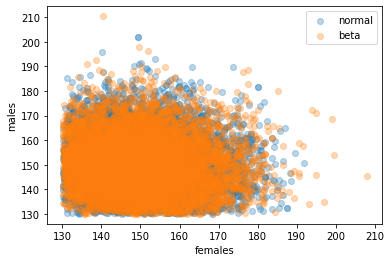

In [28]:
plt.scatter(norm3[-1][1].draws_pd(['F0'])['F0'], norm3[-1][1].draws_pd(['M0'])['M0'], alpha=0.3, label='normal')
plt.scatter(beta3[-1][1].draws_pd(['F0'])['F0'], beta3[-1][1].draws_pd(['M0'])['M0'], alpha=0.3, label='beta')
plt.xlabel('females')
plt.ylabel('males')
plt.legend()

In [32]:
beta3[-1][1].diagnose()

INFO:cmdstanpy:Processing csv files: /run/user/1000/tmpjiguiiwb/sib_full-202109232035-1-dfi1bmw5.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-2-vdx2wix1.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-3-z339lglk.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-4-5l9swl0l.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /run/user/1000/tmpjiguiiwb/sib_full-202109232035-1-dfi1bmw5.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-2-vdx2wix1.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-3-z339lglk.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-4-5l9swl0l.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [4]:
df4 = pd.read_csv('/home/alex/src/ckmr/Piru_mykiss-Run1.BestConfig.txt')
df4 = df4.groupby(['ClusterID', 'MotherID', 'FatherID'], as_index=False).count()
df4 = df4.rename(columns={'OffspringID': 'Count'})
df4 = df4[df4['Count'] > 0]

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [5]:
dfs4 = [sub_sample(df4, p=p) for p in np.linspace(0.1, 1.0, 19)]
norm4 = sample_data(dfs4, method='normal', chains=4, show_progress=False, iter_sampling=2000)
beta4 = sample_data(dfs4, method='beta', chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


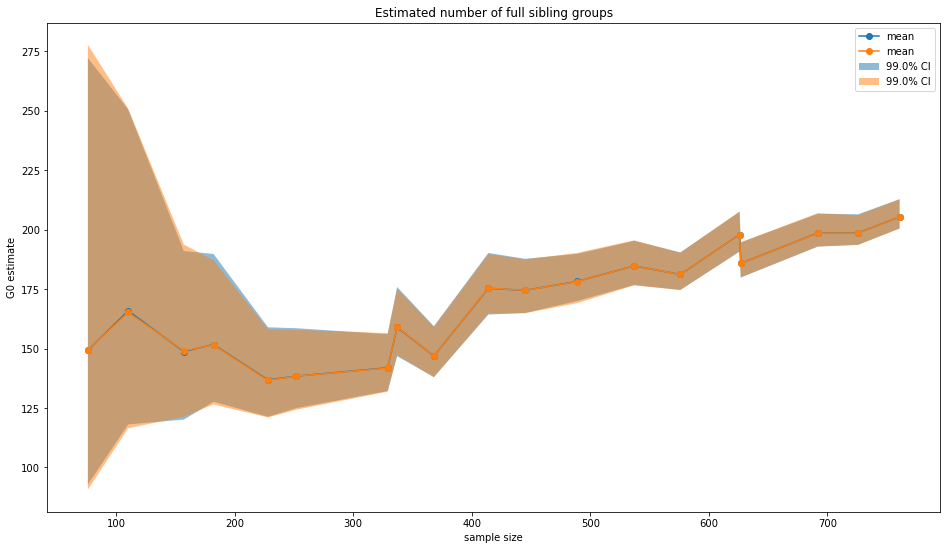

In [6]:
ax = plot_results(norm4, field='G0', title='Estimated number of full sibling groups')
ax = plot_results(beta4, field='G0', title='Estimated number of full sibling groups', ax=ax)
ax.legend()

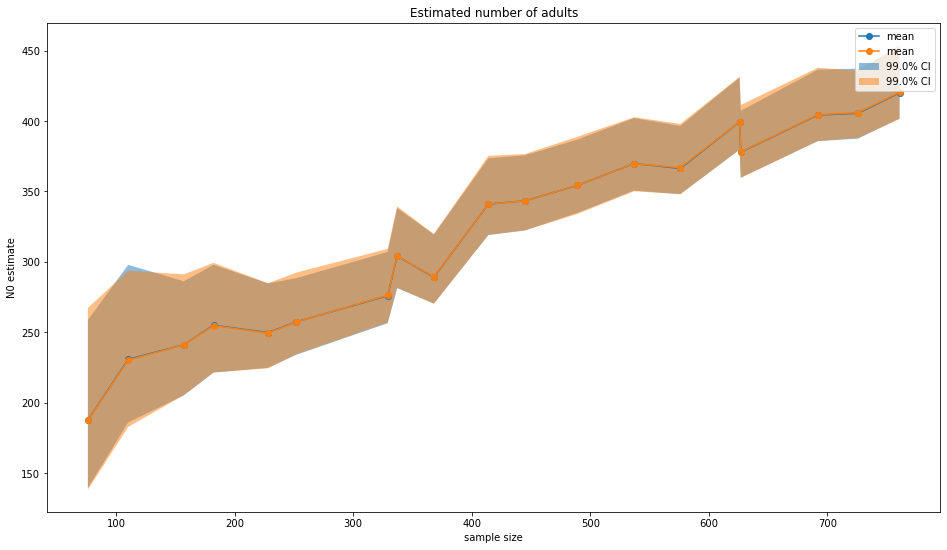

In [7]:
ax = plot_results(norm4, field='N0', title='Estimated number of adults')
ax = plot_results(beta4, field='N0', title='Estimated number of adults', ax=ax)
ax.legend()

In [17]:
norm4[-1][1].draws_pd(['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])

,osr,M0,N0,G0,F0
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.499983,209.865960,420.051815,205.454288,210.185852
std,0.002477,7.593282,10.201329,2.467321,7.637603
min,0.491175,200.003000,400.407000,200.034000,200.003000
0.5%,0.493944,200.083995,401.826925,200.544910,200.082985
50%,0.499977,208.211000,418.840000,205.240000,208.702000
99.5%,0.506455,235.882055,452.009735,212.812395,236.952945
max,0.508406,257.472000,482.005000,218.013000,248.391000


In [18]:
beta4[-1][1].draws_pd(['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])

,osr,M0,N0,G0,F0
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.499987,210.221809,420.363382,205.486492,210.141578
std,0.002498,7.847300,10.653242,2.449659,7.991599
min,0.490155,200.003000,400.173000,200.071000,200.004000
0.5%,0.493583,200.093995,401.407970,200.446865,200.058000
50%,0.499965,208.568500,419.131500,205.288000,208.419000
99.5%,0.506034,236.535050,454.176325,212.827040,238.290410
max,0.509246,251.611000,478.828000,216.916000,264.188000


In [8]:
make_synth_data(150, 150, 130, 250)

,OffspringID,FatherID,MotherID
0,1,109,15
1,2,38,29
2,3,90,146
3,4,127,98
4,5,118,31
...,...,...,...
245,246,93,45
246,247,112,71
247,248,136,91
248,249,79,28


In [89]:
dfs5 = [preprocess_data(make_synth_data(150, 150, 370, N)) for N in range(200, 4000, 100)]
norm5 = sample_data(dfs5, method='normal', chains=4, iter=2000)
beta5 = sample_data(dfs5, method='beta', chains=4, iter=2000)

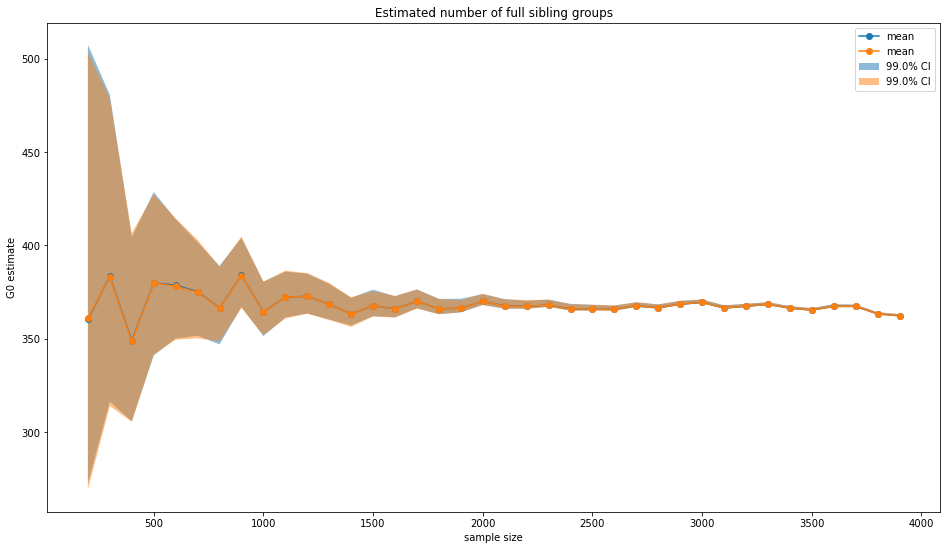

In [90]:
ax = plot_results(norm5, field='G0', title='Estimated number of full sibling groups')
ax = plot_results(beta5, field='G0', title='Estimated number of full sibling groups', ax=ax)
ax.legend()

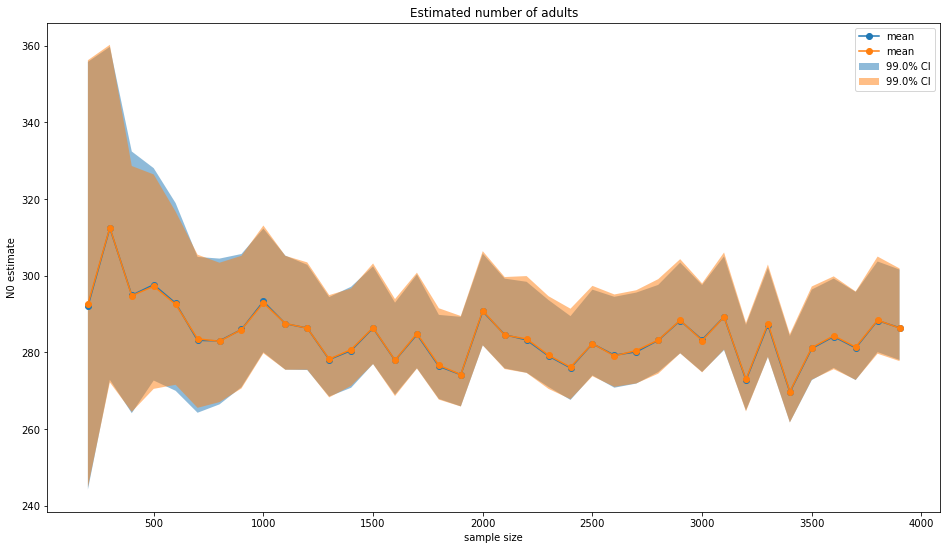

In [91]:
ax = plot_results(norm5, field='N0', title='Estimated number of adults')
ax = plot_results(beta5, field='N0', title='Estimated number of adults', ax=ax)
ax.legend()

In [92]:
norm5[-1][1].to_dataframe(pars=['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])

,chain,draw,warmup,F0,G0,M0,N0,osr,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
count,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000
mean,1.500000,499.500000,0.0,146.453981,362.208691,139.959988,286.413969,0.499965,0.888482,0.571857,2.619000,6.164000,0.0,21212.355835
std,1.118174,288.711081,0.0,3.725591,0.204093,3.958780,4.916261,0.002424,0.167655,0.054189,0.508334,2.185017,0.0,2.110277
min,0.000000,0.000000,0.0,142.002264,362.000010,135.003499,277.224495,0.490962,0.000024,0.486904,1.000000,1.000000,0.0,21208.239193
0.5%,0.000000,4.995000,0.0,142.024293,362.001173,135.032225,278.007495,0.493630,0.046899,0.486904,1.000000,3.000000,0.0,21208.861060
50%,1.500000,499.500000,0.0,145.579340,362.145650,138.969275,285.824062,0.499947,0.949506,0.586781,3.000000,7.000000,0.0,21211.975612
99.5%,3.000000,994.005000,0.0,159.803029,363.028224,153.468098,301.599029,0.506296,1.000000,0.626961,3.000000,15.000000,0.0,21219.554369
max,3.000000,999.000000,0.0,166.596725,363.365619,157.759974,307.041065,0.508640,1.000000,0.626961,5.000000,35.000000,0.0,21223.225876
